Load in packages and define functions

In [1]:
import matplotlib.pyplot as plt
import xarray
import numpy as np
import datetime
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from glob import glob
from netCDF4 import Dataset
from scipy.stats.stats import pearsonr

In [2]:
# Implementing decimal year fxn found here: https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years
# Input: array of np.datetime64 objects
# Output: same array converted into decimal year format, to be used for fitting models to a time series
def to_decimal_year(time):
    dt = pd.to_datetime(time) # converts np.datetime64 into datetime object
    dec_year = []
    for i in range(len(dt)):
        start = datetime.date(dt[i].year,1,1).toordinal()
        year_length = datetime.date(dt[i].year+1, 1, 1).toordinal() - start
        dec_year.append(dt[i].year + (float(dt[i].toordinal() - start) / year_length)) # calculates how much time has passed in the year, divides by year length, then adds to start year
    return np.array(dec_year)

# Remove trend from data by fitting a series of harmonics
# Input: array of times in np.datetime64 format, data array, number of harmonics (int), whether or not to remove trend (Boolean)
# Output: data array with mean, trend and/or seasonal cycle removed if specified
def detrend_data(t,data,num_harmonics=0, remove_trend=False):
    dyr = to_decimal_year(t) # convert from date-time to decimal year
    
    model = [np.ones(len(dyr)), dyr - np.mean(dyr)]
    for i in range(num_harmonics): # adding harmonics to model
        omega = 2*(i+1)*np.pi
        model.append(np.sin(omega*dyr))
        model.append(np.cos(omega*dyr))
    pmodel = np.linalg.pinv(np.array(model))
    
    # calculate coefficients / residuals (as specified by input)
    coefs = np.matmul(data, pmodel)
    mean = coefs[0]
    trend = coefs[1]*(dyr - np.mean(dyr))
    res_coefs = coefs[2:]
    
    seasons_model = [] # initialize model to be populated with code below
    
    if remove_trend == True: # case for removing both trend and seasonal cycle
        detrend_data = data-mean-trend
        for j in range(0,len(res_coefs),2):
            omega = (j+2)*np.pi
            detrend_data = detrend_data-(res_coefs[j]*np.sin(omega*dyr))-(res_coefs[j+1]*np.cos(omega*dyr)) 
            seasons_model.append(res_coefs[j]*np.sin(omega*dyr))
            seasons_model.append(res_coefs[j+1]*np.cos(omega*dyr))
            
    else: # case for leaving trend, removing seasonal cycle
        detrend_data = data-mean
        for j in range(0,len(res_coefs),2):
            omega = (j+2)*np.pi
            detrend_data = detrend_data-(res_coefs[j]*np.sin(omega*dyr))-(res_coefs[j+1]*np.cos(omega*dyr))
            seasons_model.append(res_coefs[j]*np.sin(omega*dyr))
            seasons_model.append(res_coefs[j+1]*np.cos(omega*dyr))
    
    seasons_model_final = np.sum(np.array(seasons_model), axis=0)
    
    results = {}
    results['data'] = detrend_data
    results['coefs'] = coefs
    results['trend'] = trend
    results['seasons_model'] = seasons_model_final
    
    return results

In [3]:
def detrend_data_from_coefs(t,data,coefs,return_seasons=False):
    dyr = to_decimal_year(t) # convert from date-time to decimal year
    mean = coefs[0]
    trend = coefs[1]*(dyr - np.mean(dyr))
    res_coefs = coefs[2:]
    
    seasons_model = [] # initialize model to be populated with code below
    
    detrend_data = data-mean-trend
    for j in range(0,len(res_coefs),2):
        omega = (j+2)*np.pi
        detrend_data = detrend_data-(res_coefs[j]*np.sin(omega*dyr))-(res_coefs[j+1]*np.cos(omega*dyr)) 
        seasons_model.append(res_coefs[j]*np.sin(omega*dyr))
        seasons_model.append(res_coefs[j+1]*np.cos(omega*dyr))
        
    if return_seasons:
        seasons_model_final = np.sum(np.array(seasons_model), axis=0)
        return detrend_data,seasons_model_final
    return detrend_data

Extract data

In [4]:
files = np.sort(glob('/Users/erickson/Documents/Data/RFROM/*.nc'))
data = xarray.open_mfdataset(files)

In [5]:
latitude_locations = [45,0,-35]
longitude_locations = [-140,-145,160]
latitude_inds = np.array([np.argmin(np.abs(l-data.variables['latitude'].values)) for l in latitude_locations])
longitude_inds = np.array([np.argmin(np.abs(np.mod(l,360)-data.variables['longitude'].values)) for l in longitude_locations])

In [6]:
yeartime = to_decimal_year(data['time'].values)
pressure = data['mean_pressure'].values

# Figure 1: Time series

In [7]:
pres = [2.5,100]
presinds = [np.argmin(np.abs(data['mean_pressure'].values-p)) for p in pres]
temps = [data['ocean_temperature'][:,ind,latitude_inds[0],longitude_inds[0]].values for ind in presinds]

In [9]:
temp_detrend = [detrend_data(data['time'].values, t, num_harmonics=6, remove_trend=True) for t in temps]

In [11]:
MHW_threshold = [np.percentile(t['data'],90) for t in temp_detrend]
MCS_threshold = [np.percentile(t['data'],10) for t in temp_detrend]

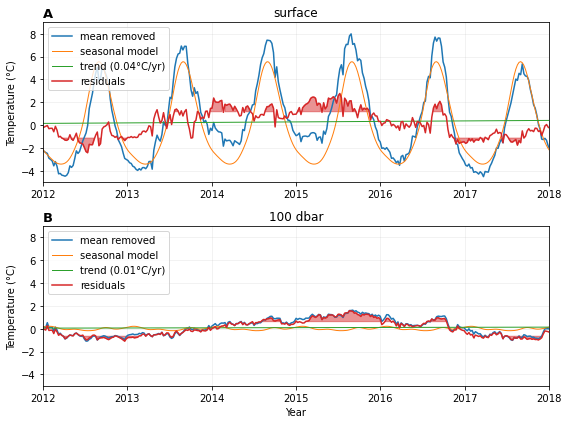

In [49]:
fig,ax = plt.subplots(2,1,figsize=(8,6))
for i in range(2):
    ax[i].plot(yeartime, temps[i]-np.mean(temps[i]),label='mean removed')
    ax[i].plot(yeartime, temp_detrend[i]['seasons_model'], label='seasonal model', lw=1) # verifying seasons model is realistic-looking
    ax[i].plot(yeartime, temp_detrend[i]['trend'], label='trend (%.02f°C/yr)'%temp_detrend[i]['coefs'][1], lw=1) # verifying trend != 0
    ax[i].plot(yeartime, temp_detrend[i]['data'], label='residuals')
    ax[i].fill_between(yeartime, MHW_threshold[i], temp_detrend[i]['data'],where=temp_detrend[i]['data']>MHW_threshold[i],color='C3',alpha=0.5)
    ax[i].fill_between(yeartime, MCS_threshold[i], temp_detrend[i]['data'], where=temp_detrend[i]['data']<MCS_threshold[i],color='C3',alpha=0.5)

for a in ax:
    a.set_ylim([-5,9])
    a.set_xlim([2012,2018])
    a.set_ylabel('Temperature (°C)')
    a.legend(loc='upper left',framealpha=0.8,ncol=1)
    a.grid(alpha=0.2)

ax[0].set_title('surface')
ax[1].set_title('100 dbar')
ax[1].set_xlabel('Year')
plt.tight_layout()

for a,panel in zip(ax,['A','B']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

plt.savefig('Figure_timeseries_final.png',dpi=300)

# Figure 2: MHW intensity map

In [54]:
nc = Dataset('MHW_intensity.nc','r')
ncvars = nc.variables
MHW_intensity = ncvars['MHW_intensity'][[0,1,3]]
MHW_intensity[MHW_intensity==0] = np.nan

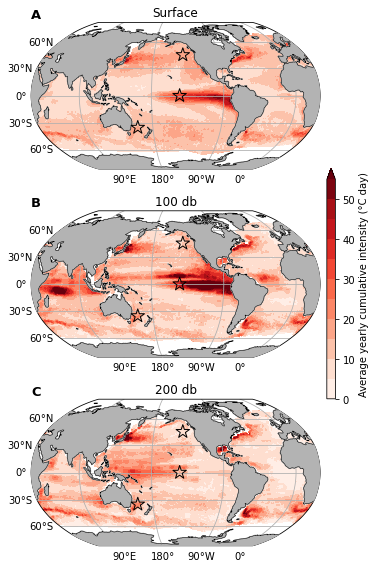

In [55]:
fig = plt.figure(figsize=(6,8))
ax = (fig.add_subplot(3, 1, 1, projection=ccrs.Robinson(210)),
      fig.add_subplot(3, 1, 2, projection=ccrs.Robinson(210)),
      fig.add_subplot(3, 1, 3, projection=ccrs.Robinson(210)))
for a in ax:
    a.set_global()
    a.coastlines(zorder=9,lw=0.5)
    a.add_feature(cfeature.LAND, color='0.7',zorder=3)
    a.add_feature(cfeature.LAND, color='0.7',zorder=3)
    gl = a.gridlines(draw_labels=True,xlocs=np.arange(-180,180,90))
    gl.top_labels = False
    a.scatter(longitude_locations,latitude_locations,marker='*',s=200,transform=ccrs.PlateCarree(),zorder=10,facecolor='none',edgecolor='k')

c = ax[0].contourf(ncvars['longitude'][:],ncvars['latitude'][:],MHW_intensity[0],cmap=plt.cm.Reds,levels=np.arange(0,56,5),extend='max',transform=ccrs.PlateCarree())
ax[1].contourf(ncvars['longitude'][:],ncvars['latitude'][:],MHW_intensity[1],cmap=plt.cm.Reds,levels=np.arange(0,56,5),extend='max',transform=ccrs.PlateCarree())
ax[2].contourf(ncvars['longitude'][:],ncvars['latitude'][:],MHW_intensity[2],cmap=plt.cm.Reds,levels=np.arange(0,56,5),extend='max',transform=ccrs.PlateCarree())
ax[0].set_title('Surface')
ax[1].set_title('100 db')
ax[2].set_title('200 db')

plt.tight_layout()

cax = fig.add_axes([0.85,0.3,0.02,0.4])
cbar = fig.colorbar(c,cax=cax,label='Average yearly cumulative intensity (°C day)')

for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

plt.savefig('Figure_MHW_intensity_final.png',dpi=300)

# Figure 3: temperature anomalies

In [56]:
ocean_temperatures = np.array([data['ocean_temperature'][:,:,latind,lonind].values for latind,lonind in zip(latitude_inds,longitude_inds)])

In [57]:
temp_detrend = np.empty(shape=ocean_temperatures.shape)
for i in range(len(temp_detrend)):
    print(i,end='')
    for j in range(len(pressure)):
        print('.',end='')
        temp_detrend[i,:,j] = detrend_data(data['time'].values, ocean_temperatures[i,:,j], num_harmonics=6, remove_trend=True)['data']
    print('')

0............................................
1............................................
2............................................


In [58]:
percentile_limits = np.percentile(temp_detrend,[10,90],axis=1)

In [59]:
temp_percentile = np.zeros(shape=temp_detrend.shape)
for i in range(len(temp_detrend)):
    for j in range(len(data['mean_pressure'])):
        temp_percentile[i,temp_detrend[i,:,j]>percentile_limits[1,i,j],j] = 1
        temp_percentile[i,temp_detrend[i,:,j]<percentile_limits[0,i,j],j] = -1

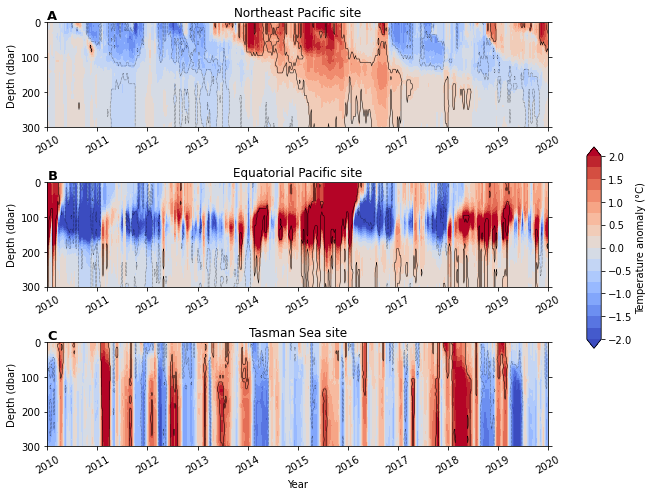

In [64]:
fig,ax = plt.subplots(3,1,figsize=(10,7))
for i in range(3):
    c = ax[i].contourf(data['time'].values,pressure,temp_detrend[i].T,cmap=plt.cm.coolwarm,levels=np.arange(-2,2.01,.25),extend='both')
    #ax[i].contour(data['time'].values,pressure,temp_detrend[i].T,levels=np.arange(-10,10.1,1),colors='k',linewidths=0.25)
    ax[i].contour(data['time'].values,pressure,temp_percentile[i].T,levels=[-1.5,-.5,0.5,1.5],colors='k',linestyles=['-',':','-'],linewidths=[0.5])
    ax[i].set_ylim([300,0])
    ax[i].tick_params(axis='x', labelrotation=30)
    ax[i].set_ylabel('Depth (dbar)')
    ax[i].yaxis.set_ticks_position('both')
ax[2].set_xlabel('Year')
ax[0].set_xlim([datetime.date(2010,1,1),datetime.date(2020,1,1)])
ax[1].set_xlim([datetime.date(2010,1,1),datetime.date(2020,1,1)])
ax[2].set_xlim([datetime.date(2010,1,1),datetime.date(2020,1,1)])
ax[0].set_title('Northeast Pacific site')
ax[1].set_title('Equatorial Pacific site')
ax[2].set_title('Tasman Sea site')
plt.tight_layout(rect=(0,0,0.8,1))
cax = fig.add_axes([0.82,0.3,0.02,0.4])
plt.colorbar(c,cax=cax,label='Temperature anomaly (°C)')
for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

plt.savefig('Figure_anomalies_final.png',dpi=300)

# Figure 4: lagged correlations

In [65]:
def lag_corr(array1,array2,lag):
    if lag>0:
        return pearsonr(array2[lag:-1],array1[:-1-lag])
    elif lag<0:
        l = int(-1.*lag)
        return pearsonr(array1[l:-1],array2[:-1-l])
    else:
        return pearsonr(array1,array2)

In [66]:
lags = np.arange(-52*3,52*3+1)
lagged_corr = np.zeros(shape=(3,len(pressure),len(lags)))*np.nan
lagged_p = np.zeros(shape=(3,len(pressure),len(lags)))*np.nan
for i in range(3):
    print(i,end='')
    for j in range(len(pressure)):
        print('.',end='')
        for k in range(len(lags)):
            lagged_corr[i,j,k],lagged_p[i,j,k] = lag_corr(temp_detrend[i,:,0],temp_detrend[i,:,j],lags[k])
    print('')

0............................................
1............................................
2............................................


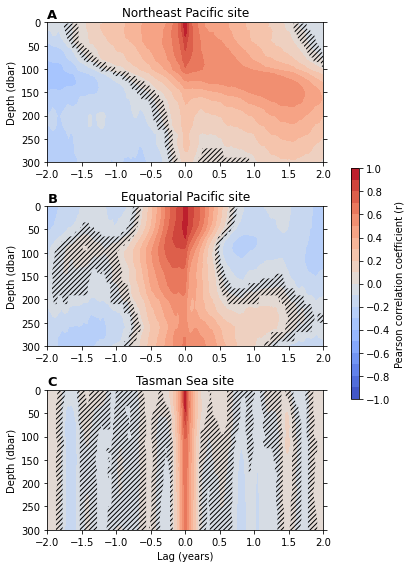

In [67]:
fig,ax = plt.subplots(3,1,figsize=(6,8))
for i in range(3):
    c = ax[i].contourf(lags/52,pressure,lagged_corr[i],cmap=plt.cm.coolwarm,levels=np.arange(-1,1.01,.1))
    ax[i].contourf(lags/52,pressure,lagged_p[i]>0.05,levels=[0.5,1.5],hatches=['/////'],colors=['none'])
    #ax[i].plot(lags[np.argmax(lagged_corr[i],axis=1)]/52,data['mean_pressure'].values,c='k',ls=':')
    ax[i].set_ylim([300,0])
    ax[i].set_xlim([-2,2])
    ax[i].set_ylabel('Depth (dbar)')
    ax[i].yaxis.set_ticks_position('both')
ax[2].set_xlabel('Lag (years)')
ax[0].set_title('Northeast Pacific site')
ax[1].set_title('Equatorial Pacific site')
ax[2].set_title('Tasman Sea site')
plt.tight_layout(rect=(0,0,0.8,1))
cax = fig.add_axes([0.82,0.3,0.02,0.4])
plt.colorbar(c,cax=cax,label='Pearson correlation coefficient (r)',ticks=np.arange(-1,1.01,.2))
for a,panel in zip(ax,['A','B','C']):
    a.annotate(panel,(0.0,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

plt.savefig('Figure_lagged_correlation_final.png',dpi=300)

# Figure 5: lagged correlation maps

In [7]:
nc = Dataset('lagged_correlation_analysis.nc','r')
ncvars = nc.variables
print(ncvars.keys())

dict_keys(['lag', 'dep', 'lat', 'lon', 'lagged_corr', 'lagged_p'])


In [8]:
lags = ncvars['lag'][:]

In [9]:
max_correlation_arg = np.argmax(ncvars['lagged_corr'][:],axis=0)
max_correlation = np.max(ncvars['lagged_corr'][:],axis=0)

In [10]:
shape = max_correlation_arg.shape
max_correlation_p = np.empty(shape=shape)
for i in range(shape[0]):
    print(i,end='')
    for j in range(shape[1]):
        print('.',end='')
        for k in range(shape[2]):
            max_correlation_p[i,j,k] = ncvars['lagged_p'][max_correlation_arg[i,j,k],i,j,k]
    print('')

0..

/var/folders/6y/5q056x5d66vd__hhd8h109fw0002np/T/ipykernel_52973/1421168711.py:8: UserWarning: Warning: converting a masked element to nan.
  max_correlation_p[i,j,k] = ncvars['lagged_p'][max_correlation_arg[i,j,k],i,j,k]


..................................................................................................................................................................................
1....................................................................................................................................................................................
2....................................................................................................................................................................................
3....................................................................................................................................................................................


In [11]:
max_correlation_lag = lags[max_correlation_arg].astype('float')

In [12]:
shape = max_correlation_arg.shape
max_significant_lag = np.empty(shape=shape)
for i in [1,3]:
    print(i,end='')
    for j in range(shape[1]):
        print('.',end='')
        for k in range(shape[2]):
            if np.isnan(max_correlation_p[i,j,k]):
                max_significant_lag[i,j,k] = np.nan
                continue
            if max_correlation_p[i,j,k]>0.05:
                max_significant_lag[i,j,k] = np.nan
                continue
            # find most significant index larger than maximum correlation lag
            inds = np.arange(max_correlation_arg[i,j,k],len(lags))
            if len(inds)==0:
                max_significant_lag[i,j,k] = np.nan
                continue
            nonsignificant_inds = np.where(ncvars['lagged_p'][inds,i,j,k]>0.05)[0]
            if len(nonsignificant_inds)==0:
                pos_lag = np.max(lags)
            else:
                pos_lag = lags[inds[nonsignificant_inds[0]]-1]
            # find most significant index smaller than maximum correlation lag
            inds = np.arange(0,max_correlation_arg[i,j,k])
            if len(inds)==0:
                max_significant_lag[i,j,k] = np.nan
                continue
            nonsignificant_inds = np.where(ncvars['lagged_p'][inds,i,j,k]>0.05)[0]
            if len(nonsignificant_inds)==0:
                neg_lag = np.min(lags)
            else:
                neg_lag = lags[inds[nonsignificant_inds[-1]]+1]
            max_significant_lag[i,j,k] = pos_lag if np.abs(pos_lag)>np.abs(neg_lag) else neg_lag
                    
                
            

1....................................................................................................................................................................................3....................................................................................................................................................................................

In [13]:
max_correlation_plot = max_correlation[[1,3]].data
max_correlation_lag_plot = max_correlation_lag[[1,3]]
max_significant_lag_plot = max_significant_lag[[1,3]]

In [14]:
max_correlation_plot[max_correlation[[1,3]].mask] = np.nan
max_correlation_plot[max_correlation_p[[1,3]]>0.05] = np.nan
max_correlation_lag_plot[max_correlation[[1,3]].mask] = np.nan
max_correlation_lag_plot[max_correlation_p[[1,3]]>0.05] = np.nan
max_significant_lag_plot[max_correlation[[1,3]].mask] = np.nan
max_significant_lag_plot[max_correlation_p[[1,3]]>0.05] = np.nan

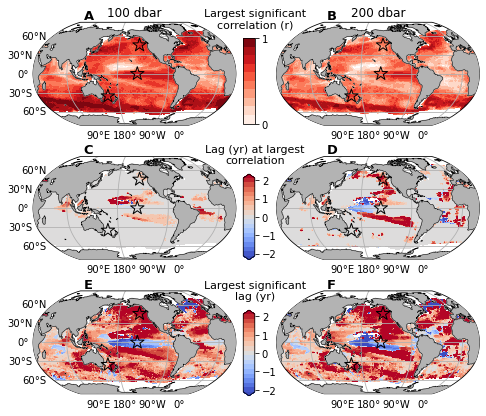

In [15]:
fig = plt.figure(figsize=(8, 7))

ax = (fig.add_subplot(3, 2, 1, projection=ccrs.Robinson(210)),
      fig.add_subplot(3, 2, 2, projection=ccrs.Robinson(210)),
      fig.add_subplot(3, 2, 3, projection=ccrs.Robinson(210)),
      fig.add_subplot(3, 2, 4, projection=ccrs.Robinson(210)),
      fig.add_subplot(3, 2, 5, projection=ccrs.Robinson(210)),
      fig.add_subplot(3, 2, 6, projection=ccrs.Robinson(210)),)

fig.text(x=0.51,y=0.90,s='Largest significant\ncorrelation (r)',ha='center',va='top',fontsize=11)
fig.text(x=0.51,y=0.63,s='Lag (yr) at largest\ncorrelation',ha='center',va='top',fontsize=11)
fig.text(x=0.51,y=0.36,s='Largest significant\nlag (yr)',ha='center',va='top',fontsize=11)

'''caxs = (fig.add_axes([0.45,0.68,0.12,0.02]),
        fig.add_axes([0.45,0.42,0.12,0.02]),
        fig.add_axes([0.45,0.15,0.12,0.02]))''';
caxs = (fig.add_axes([0.49,0.67,0.02,0.17]),
        fig.add_axes([0.49,0.40,0.02,0.17]),
        fig.add_axes([0.49,0.13,0.02,0.17]))

for a in ax:
    a.set_global()
    a.coastlines(zorder=9,lw=0.5)
    a.add_feature(cfeature.LAND, color='0.7',zorder=3)
    a.scatter(longitude_locations,latitude_locations,marker='*',s=200,transform=ccrs.PlateCarree(),zorder=10,facecolor='none',edgecolor='k')
c1 = ax[0].contourf(ncvars['lon'][:],ncvars['lat'][:],max_correlation_plot[0],levels=np.arange(0,1.05,.1),cmap=plt.cm.Reds,transform=ccrs.PlateCarree())
ax[1].contourf(ncvars['lon'][:],ncvars['lat'][:],max_correlation_plot[1],levels=np.arange(0,1.05,.1),cmap=plt.cm.Reds,transform=ccrs.PlateCarree())
c2 = ax[2].contourf(ncvars['lon'][:],ncvars['lat'][:],max_correlation_lag_plot[0]/52,levels=np.arange(-2.125,2.25,.25),extend='both',cmap=plt.cm.coolwarm,transform=ccrs.PlateCarree())
ax[3].contourf(ncvars['lon'][:],ncvars['lat'][:],max_correlation_lag_plot[1]/52,levels=np.arange(-2.125,2.25,.25),extend='both',cmap=plt.cm.coolwarm,transform=ccrs.PlateCarree())
c3 = ax[4].contourf(ncvars['lon'][:],ncvars['lat'][:],max_significant_lag_plot[0]/52,levels=np.arange(-2.125,2.25,.25),extend='both',cmap=plt.cm.coolwarm,transform=ccrs.PlateCarree())
ax[5].contourf(ncvars['lon'][:],ncvars['lat'][:],max_significant_lag_plot[1]/52,levels=np.arange(-2.125,2.25,.25),extend='both',cmap=plt.cm.coolwarm,transform=ccrs.PlateCarree())

gl = ax[0].gridlines(draw_labels=True,xlocs=np.arange(-180,180,90))
gl.top_labels = False
gl = ax[2].gridlines(draw_labels=True,xlocs=np.arange(-180,180,90))
gl.top_labels = False
gl = ax[4].gridlines(draw_labels=True,xlocs=np.arange(-180,180,90))
gl.top_labels = False
gl = ax[1].gridlines(draw_labels=True,xlocs=np.arange(-180,180,90))
gl.top_labels = False
gl.left_labels = False
gl = ax[3].gridlines(draw_labels=True,xlocs=np.arange(-180,180,90))
gl.top_labels = False
gl.left_labels = False
gl = ax[5].gridlines(draw_labels=True,xlocs=np.arange(-180,180,90))
gl.top_labels = False
gl.left_labels = False

plt.colorbar(c1,cax=caxs[0],orientation='vertical',ticks=[-1,0,1])
plt.colorbar(c2,cax=caxs[1],orientation='vertical',ticks=[-2,-1,0,1,2])
plt.colorbar(c3,cax=caxs[2],orientation='vertical',ticks=[-2,-1,0,1,2])

ax[0].set_title('100 dbar')
ax[1].set_title('200 dbar')


for a,panel in zip(ax,['A','B','C','D','E','F']):
    a.annotate(panel,(0.25,1.03),xycoords='axes fraction',fontweight='bold',fontsize=13)

plt.savefig('Figure_correlation_maps_final.png',dpi=300)